In [1]:
import tensorflow as tf
from tensorflow.python.eager import context
from tensorflow.python.framework import ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import resource_variable_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.ops import variable_scope
from tensorflow.python.training import optimizer

import numpy as np
import matplotlib.pyplot as plt

In [2]:
class PADAM(optimizer.Optimizer):
    """Implementation of PADAM
    See https://arxiv.org/pdf/1806.06763v1.pdf
    @@__init__
    """
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, p=0.5, epsilon=1e-8, use_locking=False, name="PADAM"):
        super(PADAM, self).__init__(use_locking, name)
        self._lr = learning_rate
        self._beta1 = beta1
        self._beta2 = beta2
        self._p=p
        self._epsilon=epsilon
        
        # Tensor versions of the constructor arguments, created in _prepare().
        self._beta1_t = None
        self._beta2_t = None
        self._lr_t = None
        self._epsilon_t = None
        self._p_t=None
        
        self._beta1_power = None
        self._beta2_power = None
    
    def _create_slots(self, var_list):
        first_var = min(var_list, key=lambda x: x.name)

        create_new = self._beta1_power is None
        if not create_new and context.in_graph_mode():
            create_new = (self._beta1_power.graph is not first_var.graph)

        if create_new:
            with ops.colocate_with(first_var):
                self._beta1_power = variable_scope.variable(self._beta1, name="beta1_power", trainable=False)
                self._beta2_power = variable_scope.variable(self._beta2, name="beta2_power", trainable=False)
        # Create slots for the first and second moments.
        for v in var_list:
            self._zeros_slot(v, "m", self._name)
            self._zeros_slot(v, "v", self._name)
            self._zeros_slot(v, "vhat", self._name)

    def _prepare(self):
        self._lr_t = ops.convert_to_tensor(self._lr, name="lr")
        self._beta1_t = ops.convert_to_tensor(self._beta1, name="beta1")
        self._beta2_t = ops.convert_to_tensor(self._beta2, name="beta2")
        self._epsilon_t = ops.convert_to_tensor(self._epsilon, name="epsilon")
        self._p_t=ops.convert_to_tensor(self._p, name="p")
        
    def _apply_dense(self, grad, var):
        beta1_power = math_ops.cast(self._beta1_power, var.dtype.base_dtype)
        beta2_power = math_ops.cast(self._beta2_power, var.dtype.base_dtype)
        lr_t = math_ops.cast(self._lr_t, var.dtype.base_dtype)
        beta1_t = math_ops.cast(self._beta1_t, var.dtype.base_dtype)
        beta2_t = math_ops.cast(self._beta2_t, var.dtype.base_dtype)
        epsilon_t = math_ops.cast(self._epsilon_t, var.dtype.base_dtype)
        p_t=math_ops.cast(self._p_t, var.dtype.base_dtype)

        lr = (lr_t * math_ops.sqrt(1 - beta2_power) / (1 - beta1_power))

        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, "m")
        m_scaled_g_values = grad * (1 - beta1_t)
        m_t = state_ops.assign(m, beta1_t * m + m_scaled_g_values, use_locking=self._use_locking)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, "v")
        v_scaled_g_values = (grad * grad) * (1 - beta2_t)
        v_t = state_ops.assign(v, beta2_t * v + v_scaled_g_values, use_locking=self._use_locking)

        # padam
        vhat = self.get_slot(var, "vhat")
        vhat_t = state_ops.assign(vhat, math_ops.maximum(v_t, vhat))
        v_partial = math_ops.pow(vhat_t, p_t)

        var_update = state_ops.assign_sub(var, lr * m_t / (v_partial + epsilon_t), use_locking=self._use_locking)
        return control_flow_ops.group(*[var_update, m_t, v_t, vhat_t])

    def _resource_apply_dense(self, grad, var):
        var = var.handle
        beta1_power = math_ops.cast(self._beta1_power, grad.dtype.base_dtype)
        beta2_power = math_ops.cast(self._beta2_power, grad.dtype.base_dtype)
        lr_t = math_ops.cast(self._lr_t, grad.dtype.base_dtype)
        beta1_t = math_ops.cast(self._beta1_t, grad.dtype.base_dtype)
        beta2_t = math_ops.cast(self._beta2_t, grad.dtype.base_dtype)
        epsilon_t = math_ops.cast(self._epsilon_t, grad.dtype.base_dtype)
        p_t=math_ops.cast(self._p_t, var.dtype.base_dtype)

        lr = (lr_t * math_ops.sqrt(1 - beta2_power) / (1 - beta1_power))

        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, "m").handle
        m_scaled_g_values = grad * (1 - beta1_t)
        m_t = state_ops.assign(m, beta1_t * m + m_scaled_g_values, use_locking=self._use_locking)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, "v").handle
        v_scaled_g_values = (grad * grad) * (1 - beta2_t)
        v_t = state_ops.assign(v, beta2_t * v + v_scaled_g_values, use_locking=self._use_locking)

        # padam
        vhat = self.get_slot(var, "vhat").handle
        vhat_t = state_ops.assign(vhat, math_ops.maximum(v_t, vhat))
        v_partial = math_ops.pow(vhat_t, p_t)

        var_update = state_ops.assign_sub(var, lr * m_t / (v_partial + epsilon_t), use_locking=self._use_locking)
        return control_flow_ops.group(*[var_update, m_t, v_t, vhat_t])

    def _apply_sparse_shared(self, grad, var, indices, scatter_add):
        beta1_power = math_ops.cast(self._beta1_power, var.dtype.base_dtype)
        beta2_power = math_ops.cast(self._beta2_power, var.dtype.base_dtype)
        lr_t = math_ops.cast(self._lr_t, var.dtype.base_dtype)
        beta1_t = math_ops.cast(self._beta1_t, var.dtype.base_dtype)
        beta2_t = math_ops.cast(self._beta2_t, var.dtype.base_dtype)
        epsilon_t = math_ops.cast(self._epsilon_t, var.dtype.base_dtype)
        p_t=math_ops.cast(self._p_t, var.dtype.base_dtype)

        lr = (lr_t * math_ops.sqrt(1 - beta2_power) / (1 - beta1_power))

        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, "m")
        m_scaled_g_values = grad * (1 - beta1_t)
        m_t = state_ops.assign(m, m * beta1_t, use_locking=self._use_locking)
        with ops.control_dependencies([m_t]):
            m_t = scatter_add(m, indices, m_scaled_g_values)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, "v")
        v_scaled_g_values = (grad * grad) * (1 - beta2_t)
        v_t = state_ops.assign(v, v * beta2_t, use_locking=self._use_locking)
        with ops.control_dependencies([v_t]):
            v_t = scatter_add(v, indices, v_scaled_g_values)

        # padam
        vhat = self.get_slot(var, "vhat")
        vhat_t = state_ops.assign(vhat, math_ops.maximum(v_t, vhat))
        v_partial = math_ops.pow(vhat_t, p_t)
        var_update = state_ops.assign_sub(var, lr * m_t / (v_partial + epsilon_t), use_locking=self._use_locking)
        return control_flow_ops.group(*[var_update, m_t, v_t, vhat_t])

    def _apply_sparse(self, grad, var):
        return self._apply_sparse_shared(
            grad.values,
            var,
            grad.indices,
            lambda x, i, v: state_ops.
            scatter_add(  # pylint: disable=g-long-lambda
                x, i, v, use_locking=self._use_locking
            )
        )

    def _resource_scatter_add(self, x, i, v):
        with ops.control_dependencies([resource_variable_ops.resource_scatter_add(x.handle, i, v)]):
            return x.value()

    def _resource_apply_sparse(self, grad, var, indices):
        return self._apply_sparse_shared(grad, var, indices, self._resource_scatter_add)

    def _finish(self, update_ops, name_scope):
        # Update the power accumulators.
        with ops.control_dependencies(update_ops):
            with ops.colocate_with(self._beta1_power):
                update_beta1 = self._beta1_power.assign(
                    self._beta1_power * self._beta1_t, use_locking=self._use_locking
                )
                update_beta2 = self._beta2_power.assign(
                    self._beta2_power * self._beta2_t, use_locking=self._use_locking
                )
        return control_flow_ops.group(*update_ops + [update_beta1, update_beta2], name=name_scope)


# Testing the performance of the optimizers

In [3]:
#Comparision between the optimizers
def RosenbrockOpt(optimizer,MAX_EPOCHS = 4000, MAX_STEP = 100):
    '''
    returns distance of each step*MAX_STEP w.r.t minimum (1,1)
    '''
    x1_data = tf.Variable(initial_value=tf.random_uniform([1], minval=-3, maxval=3,seed=0),name='x1')
    x2_data = tf.Variable(initial_value=tf.random_uniform([1], minval=-3, maxval=3,seed=1), name='x2')

    y = tf.add(tf.pow(tf.subtract(1.0, x1_data), 2.0),
    tf.multiply(100.0, tf.pow(tf.subtract(x2_data, tf.pow(x1_data, 2.0)), 2.0)), 'y')

    global_step_tensor = tf.Variable(0, trainable=False, name='global_step')

    train = optimizer.minimize(y,global_step=global_step_tensor)

    sess = tf.Session()

    init = tf.global_variables_initializer()#tf.initialize_all_variables()
    sess.run(init)

    minx = 1.0
    miny = 1.0

    distance = []
    xx_ = sess.run(x1_data)
    yy_ = sess.run(x2_data)
#     print(0,xx_,yy_,np.sqrt((minx-xx_)**2+(miny-yy_)**2))
    for step in range(MAX_EPOCHS):
      _, xx_, yy_, zz_ = sess.run([train,x1_data,x2_data,y])
      if step % MAX_STEP == 0:
#          print(step+1, xx_,yy_, zz_)
         distance += [ np.sqrt((minx-xx_)**2+(miny-yy_)**2)]
    sess.close()
    return distance

Instructions for updating:
Colocations handled automatically by placer.


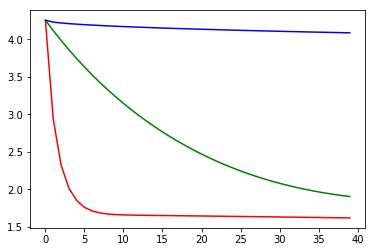

In [4]:
#Plot the convergence graphs
plt.plot(RosenbrockOpt(PADAM(p=0.3)), color="red")
plt.plot(RosenbrockOpt(tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8)), color="green")
plt.plot(RosenbrockOpt(tf.train.AdagradOptimizer(learning_rate=0.001)), color="blue")
plt.show()

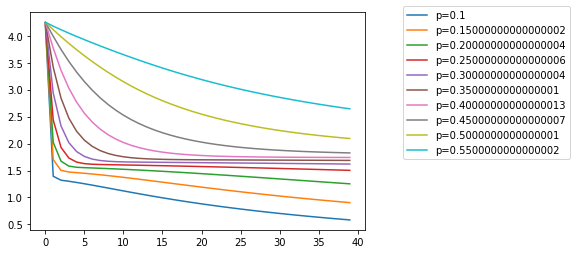

In [5]:
#Plot the convergence graph for different partial adaptive parameter
for i in np.arange(0.1,0.6,0.05):
    plt.plot(RosenbrockOpt(PADAM(p=i)), label="p="+str(i))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()